![cell_proportion](./images/cell_proportion.png)

## Classification

Classification is a key task as the relative proportion of the different white blood cells
categories indicates the presence or not of a pathology.

This part's goal is to leverage an open-source dataset of white blood cells in order to
train a Deep Learning model to perform classification.

In [3]:
!pip install medmnist

  Using cached medmnist-3.0.2-py3-none-any.whl.metadata (14 kB)
  Using cached scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached scikit_image-0.25.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached fire-0.7.0-py3-none-any.whl
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached tifffile-2025.5.10-py3-none-any.whl.metadata (31 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached medmnist-3.0.2-py3-none-any.whl (25 kB)
Using cached scikit_image-0.25.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.8 MB)
Using cached imageio-2.37.0-py3-none-any.whl (315 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached tifffile-2025.5.10-py3-none-any.whl (226 kB)
Using cached scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86

In [4]:
# Let's load the dataset
import medmnist
from medmnist import INFO, Evaluator, BloodMNIST

train_dataset = BloodMNIST(split="train", size=64, download=True)
val_dataset = BloodMNIST(split="val", size=64, download=True)
test_dataset = BloodMNIST(split="test", size=64, download=True)

Using downloaded and verified file: /home/guevel/.medmnist/bloodmnist_64.npz
Using downloaded and verified file: /home/guevel/.medmnist/bloodmnist_64.npz
Using downloaded and verified file: /home/guevel/.medmnist/bloodmnist_64.npz


This dataset contains images of white blood cells that are divided between 8 categories:

- basophil
- eosinophil
- erythroblast
- immature granulocytes
- lymphocyte
- monocyte
- neutrophil
- platelet

### Understand an image

Image's class is: platelet



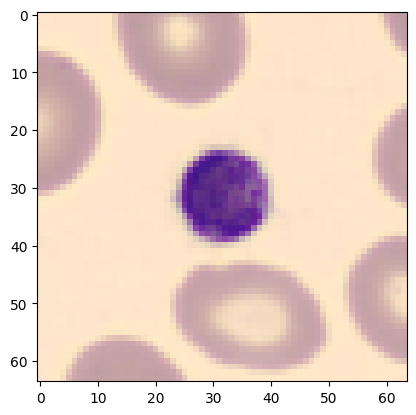

In [56]:
import random
import matplotlib.pyplot as plt

train_size = len(train_dataset)

label_dict = train_dataset.info["label"]
img, label = train_dataset[random.randint(0, train_size)]

print(f"Image's class is: {label_dict.get(str(label[0]))}\n")
plt.imshow(img)
plt.show()

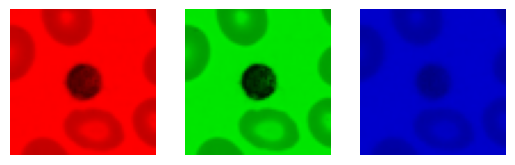

In [57]:
import numpy as np

image = np.array(img.convert("RGB"))
figure, plots = plt.subplots(ncols=3, nrows=1)
for i, subplot in zip(range(3), plots):
    temp = np.zeros(image.shape, dtype='uint8')
    temp[:,:,i] = image[:,:,i]
    subplot.imshow(temp)
    subplot.set_axis_off()
plt.show()

The first step is to create a [dataset](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html)
object in order to use pytorch's functions for the training of our model.

### Create the data objects

In [4]:
# The first step is to make a dataset, for this we need to create our own custom object
from torch.utils.data import Dataset


class CustomDataset(Dataset):

    def __init__(self, data, transform):
        # initialization method
        pass

    def __len__(self):
        # should return the number of elements of the dataset
        pass

    def __getitem__(self, idx):
        # should return the element of the dataset at index idx
        pass

In [60]:
# %load ../src/custom_dataset.py
from torch.utils.data import Dataset

class CustomDataset(Dataset):

    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]

        if self.transform:
            img = self.transform(img)

        return img, label


In [61]:
import torchvision.transforms as transforms

# Here we need a transform vision to convert the data which are PIL images into vectors
transform = transforms.ToTensor()

training_dataset = CustomDataset(train_dataset, transform)
validation_dataset = CustomDataset(val_dataset, transform)

Then we can make a dataloader in order to load the data by batches and accelerate
the training process

In [62]:
# Make your own dataloader
from torch.utils.data import DataLoader

train_loader = DataLoader(training_dataset, batch_size=64)
valid_loader = DataLoader(validation_dataset, batch_size=64)

### Create the model

The model we are going to use for this task are Convolutional Neural Networks
([CNN](https://poloclub.github.io/cnn-explainer/)), and especially a family
of them called [ResNets](https://arxiv.org/abs/1512.03385).  


In [63]:
# We create a model from a pretrained point
from torchvision import models

model = models.resnet18(pretrained=True)

In [12]:
# You can also make your own model architecture!
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()
        # create layers here
        # self.l1 = ...

    def forward(self, x):
        # here the output should be a vector of size num_classes
        pass

In [14]:
# Uncomment below and run this cell to make the solution appear
# %load ../src/net.py

### Training loop

In [64]:
# Now we need to make an optimizer + a loss
import torch.optim as optim

# cross-entropy loss is the one used for multi classification tasks
criterion = nn.CrossEntropyLoss()

# Adam is a popular optimizer, but other could be used (SGD, Adamw...)
optimizer = optim.Adam(model.parameters())

Now we have everything necessary in order to launch the training process.  
> ToDo : Find an image to illustrate training loop

In [65]:
# %load ../src/training.py
import torch
from tqdm import tqdm

device = torch.device("cuda")
model.to(device)

n_epoch = 10

for epoch in range(n_epoch):
    model.train()
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epoch} [Train]")
    for inputs, labels in train_loader_tqdm:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Add a validation step
    if epoch % 5 == 0:
        model.eval()
        correct = 0
        total = 0
        val_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{n_epoch} [Valid]")
        with torch.no_grad():
            for inputs, labels in val_loader_tqdm:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                preds = outputs.argmax(dim=1)
                labels = labels.squeeze(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                acc = 100 * correct / total
                val_loader_tqdm.set_postfix(acc=f"{acc:.2f}%")
    

Epoch 10/10 [Train]: 100%|█████████████████████████████| 187/187 [00:02<00:00, 66.84it/s]


### Visualize the results

In [50]:
for data in test_loader:
    break

In [52]:
images, labels = data
images.shape

torch.Size([64, 3, 64, 64])

In [79]:
from tqdm import tqdm

def find_accuracy(model, dataloader_test, device):
    correct = 0
    total = 0
    label_test = []
    predicted_test = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader_test):
            # Move the data to the device 
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Predict the label with the trained model
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            
            # Calculate the performance
            labels = labels.squeeze(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Add the predictions & labels in the list
            label_test.extend(labels.to('cpu').tolist())
            predicted_test.extend(preds.to('cpu').tolist())

    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))
    return predicted_test, label_test, correct / total

In [80]:
# Make the test dataset
testing_dataset = CustomDataset(test_dataset, transform)
test_loader = DataLoader(testing_dataset, batch_size=64)

# Specify the device
device = torch.device("cuda")
model.to(device)

# Calculate the results
predictions, labels, acc = find_accuracy(model, test_loader, device)

100%|████████████████████████████████████████████████████| 54/54 [00:00<00:00, 80.69it/s]

Accuracy of the network on the test images: 94 %


                      precision    recall  f1-score   support

            basophil       0.84      0.98      0.91       244
          eosinophil       1.00      1.00      1.00       624
        erythroblast       0.97      0.96      0.96       311
immature granulocyte       0.92      0.82      0.87       579
          lymphocyte       0.97      0.93      0.95       243
            monocyte       0.94      0.93      0.94       284
          neutrophil       0.93      0.98      0.95       666
            platelet       1.00      1.00      1.00       470

            accuracy                           0.95      3421
           macro avg       0.95      0.95      0.95      3421
        weighted avg       0.95      0.95      0.95      3421



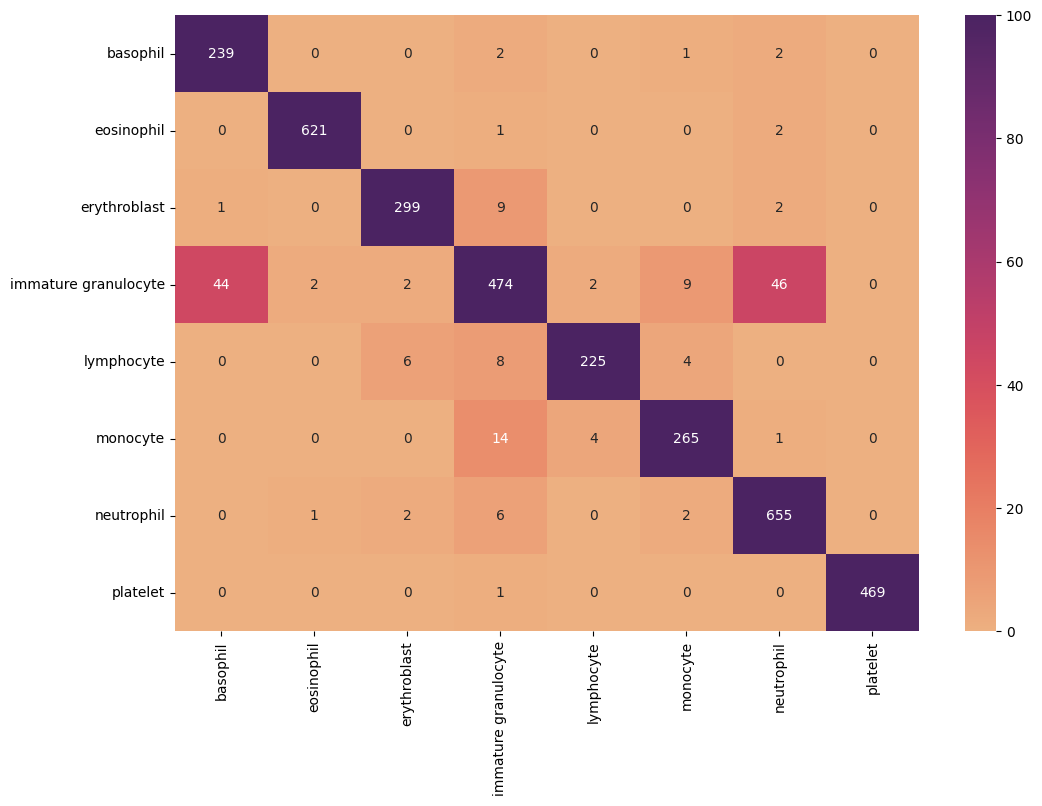

In [114]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

names = [n[:20] for n in train_dataset.info.get("label").values()]

C_matrix = pd.DataFrame(confusion_matrix(labels, predictions))
C_matrix.index = names
C_matrix.columns = names

fig = plt.figure(figsize=(12, 8))
sns.heatmap(C_matrix, annot=True, cmap="flare", vmax=100, fmt='.3g')
fig.show()

print(classification_report(labels, predictions, target_names=names))

## Foundation models

*"Foundation models"* are called like this because their outputs, called **embeddings**
are not predictions but vectors of a shape $\mathbb{R}^n$.  
The embeddings are the angular stone used for other usages, which can be classification,
segmentation, multimodal models...

In theory every architecture can be used to make a fondation model, but in practice
[Transformers](https://poloclub.github.io/transformer-explainer/) are THE type of
model commonly used,  
and have been the workhorse of the AI ecosystem for the last 8 years.

In [116]:
!pip install timm

  Using cached timm-1.0.15-py3-none-any.whl.metadata (52 kB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
Using cached timm-1.0.15-py3-none-any.whl (2.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 9.7 MB/s eta 0:00:00ta 0:00:01
Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (471 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [timm]3/4 [timm]ngface_hub]


The [model](https://arxiv.org/abs/2404.05022) we are going to used in this part has been
trained on White Blood Cells images. It:
- Uses the Vision Transformer ([ViT](https://arxiv.org/abs/2010.11929)) architecture
- Uses [DINOv2](https://github.com/facebookresearch/dinov2) as training framework
- Was trained on ~300k images from open-sourced datasets
- Contains 4 models of different sizes, ranging from 22M to 1.1B of parameters

In [167]:
import timm

# Load model from the hub
model = timm.create_model(
  model_name="hf-hub:1aurent/vit_small_patch14_224.dinobloom", # you can change the size of the loaded model here
  pretrained=True,
).eval()

# Get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transform = timm.data.create_transform(**data_config, is_training=False)

print("Below is the list of the layers contained within our model:\n")
model

Below is the list of the layers contained within our model:



VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

Here we can see the architecture of the model that we use, which is made of 12 blocks, each having:
- An Attention layer
- A Mlp layer with one hidden layer
- Normalizing and Scaling layers in between

> Can you find the dimension of the embeddings of the model that you use ?

### Make the dataset

Calculating the embeddings can be compute intensive, as we use transformer models
having huge amounts of parameters.  
However we only need to do that once, as we use them as mathematical objects, and
**we do not modify** the foumdation model afterwards.  

To do that we will create a Dataset object that will contain the embeddings calculated
for a model on a Dataset (the same as the one we used before).

In [128]:
# We are going to make a new dataset object in order to calculate the embeddings of the images.
# This allow to calculate once the embeddings and then reuse them for later applications

class EmbeddingDataset(Dataset):
    def __init__(self, dataset, model, transform, device=torch.device('cuda')):
        self.device = device
        self.transform = transform
        self.embeddings, self.labels = self._create_vectors(model, dataset)

    def _create_vectors(self, model, dataset):
        embeddings = []
        label_list = []
        model.to(self.device)
        dataloader = DataLoader(dataset, batch_size=8)

        # Loop over the data
        for batch in tqdm(dataloader):
            # Load and transform the images
            images, labels = batch
            if self.transform:
                images = self.transform(images)
            
            images = images.to(self.device)

            # Make the embeddings from the batch
            with torch.no_grad():
                embs = model(images).to("cpu")
            
            embeddings.append(embs)
            label_list.append(labels)

        # Return the calculated embeddings
        embeddings = torch.cat(embeddings, dim=0)
        label_list = torch.cat(label_list, dim=0)
        return embeddings, label_list

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx, :], self.labels[idx]

In [163]:
# Make the embedding dataset and test shapes
emb_train = EmbeddingDataset(training_dataset, model, transform)
emb_test = EmbeddingDataset(testing_dataset, model, transform)

emb_t_loader = DataLoader(embedding_train, batch_size=32)
for emb, lab in emb_t_loader:
    print(emb.shape)
    break

100%|██████████████████████████████████████████████████| 428/428 [00:27<00:00, 15.62it/s]

torch.Size([32, 384])


### Probe the embeddings quality

Now that we have an easy access to the model embeddings, we can test their quality on the dataset
that we have used before.

Popular technics are:
- k-[Nearest-Neighbour](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) (k-NN), with k being usually 1 & 20
- [Linear Probing](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) (ie fitting a linear classifier on the embeddings)
- [Multi-Layer Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) (fitting a MLP on the embeddings)

Implement here the evaluation of the above mentionned techniques!  

> Tip: You can use the sklearn library for k-NN and Linear probing

In [166]:
# %load ../src/embedding_evaluation.py
import numpy as np
import torch.nn as nn
import torch.optim as optim

from typing import Callable, Optional
from warnings import filterwarnings

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm

filterwarnings("ignore") 

def k_nearest_neighbor_eval(train_embedding, val_embedding, k=1, target_names=names):
    # Initialize the classifier
    cls = KNeighborsClassifier(n_neighbors=k)

    # Unpack the embeddings & labels
    train_array = np.array([emb for emb, _ in train_embedding])
    train_labels = np.array([lab for _, lab in train_embedding])

    val_array = np.array([emb for emb, _ in val_embedding])
    val_labels = np.array([lab for _, lab in val_embedding])
    
    # Fit the model
    cls.fit(train_array, train_labels)

    # Make the predictions
    preds = cls.predict(val_array)
    print(classification_report(val_labels, preds, target_names=target_names))

    return preds

def linear_probing_eval(train_embedding, val_embedding, target_names=names):
    # Initialize the classifier
    cls = LogisticRegression()

    # Unpack the embeddings & labels
    train_array = np.array([emb for emb, _ in train_embedding])
    train_labels = np.array([lab for _, lab in train_embedding])

    val_array = np.array([emb for emb, _ in val_embedding])
    val_labels = np.array([lab for _, lab in val_embedding])

    # Fit the model
    cls.fit(train_array, train_labels)

    # Make the predictions
    preds = cls.predict(val_array)
    print(classification_report(val_labels, preds, target_names=target_names))

    return preds

class Mlp(nn.Module):
    def __init__(
        self,
        in_features: int,
        hidden_features: Optional[int] = None,
        out_features: Optional[int] = None,
        act_layer: Callable[..., nn.Module] = nn.GELU,
        drop: float = 0.0,
        bias: bool = True,
    ) -> None:
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features, bias=bias)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features, bias=bias)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

def mlp_eval(train_embedding, val_embedding, embedding_size, num_classes=8, target_names=names):
    # Unpack the embeddings & labels
    train_loader = DataLoader(train_embedding, batch_size=64)
    val_loader = DataLoader(val_embedding, batch_size=64)
    
    # Initialize the classifier
    hidden_size = int(embedding_size * 4)
    cls = Mlp(
        in_features=embedding_size,
        hidden_features=hidden_size,
        out_features=num_classes,
    )

    # Make the fitting functions
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cls.parameters())

    # Fit the classifier
    n_epochs=10
    for epoch in tqdm(range(n_epochs)):
        cls.train()
        for emb, labels in train_loader:
            optimizer.zero_grad()
            outputs = cls(emb)
            labels = labels.squeeze(1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Make the predictions
    label_val, preds_val = [], []
    for emb, labels in val_loader:
        outputs = cls(emb)
        preds = outputs.argmax(dim=1)

        label_val.extend(labels.to('cpu').tolist())
        preds_val.extend(preds.to('cpu').tolist())

    label_array = np.array(label_val)
    preds_array = np.array(preds_val)

    print(classification_report(label_array, preds_array, target_names=target_names))

    return preds_array

print('1-NN evaluation:\n')
_ = k_nearest_neighbor_eval(emb_train, emb_test, k=1)
print('-' * 75)

print('\n20-NN evaluation:\n')
_ = k_nearest_neighbor_eval(emb_train, emb_test, k=20)
print('-' * 75)

print('\nLinear probing:\n')
_ = linear_probing_eval(emb_train, emb_test)
print('-' * 75)

print('\nMLP trained:\n')
_ = mlp_eval(emb_train, emb_test, model.embed_dim)

1-NN evaluation:

                      precision    recall  f1-score   support

            basophil       0.97      0.99      0.98       244
          eosinophil       0.99      1.00      0.99       624
        erythroblast       1.00      0.96      0.98       311
immature granulocyte       0.93      0.92      0.92       579
          lymphocyte       0.97      0.98      0.98       243
            monocyte       0.93      0.95      0.94       284
          neutrophil       0.96      0.96      0.96       666
            platelet       1.00      1.00      1.00       470

            accuracy                           0.97      3421
           macro avg       0.97      0.97      0.97      3421
        weighted avg       0.97      0.97      0.97      3421

---------------------------------------------------------------------------

20-NN evaluation:

                      precision    recall  f1-score   support

            basophil       0.98      0.99      0.98       244
          eosi

100%|████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.16it/s]

                      precision    recall  f1-score   support

            basophil       0.99      0.99      0.99       244
          eosinophil       1.00      1.00      1.00       624
        erythroblast       1.00      0.96      0.98       311
immature granulocyte       0.97      0.95      0.96       579
          lymphocyte       0.97      1.00      0.99       243
            monocyte       0.98      0.98      0.98       284
          neutrophil       0.96      0.97      0.97       666
            platelet       0.99      1.00      1.00       470

            accuracy                           0.98      3421
           macro avg       0.98      0.98      0.98      3421
        weighted avg       0.98      0.98      0.98      3421

